# Heart Attack Prediction

**Programmazione di Applicazioni Data Intensive**

**Lorenzo Dall'Ara**, lorenzo.dallara2@studio.unibo.it\
**Miriam Sonaglia**, miriam.sonaglia@studio.unibo.it

### Fonti Dataset:
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-risk-dataset-of-china \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-prediction-in-united-states \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-risk-and-prediction-dataset-in-india/data \
https://www.kaggle.com/datasets/ankushpanday2/heart-attack-prediction-in-indonesia

## Obiettivo del progetto

Questo progetto si pone l'obiettivo di realizzare un modello in grado di predire, in base a caratteristiche proprie del paziente, un possibile rischio di infarto.

## Import delle librerie
Vengono importate le librerie sotto descritte:
* **Pandas** per manipolazione e gestione di dati tabellari
* **Sklearn** per l'analisi predittiva
* **Matplotlib** per la creazione di grafici

In [427]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
CHINA_DATASET = "heart_attack_china.csv"
US_DATASET = "heart_attack_us.csv"
INDIA_DATASET = "heart_attack_india.csv"
INDONESIA_DATASET = "heart_attack_indonesia.csv"
china = pd.read_csv(CHINA_DATASET, sep=",")
unitedStates = pd.read_csv(US_DATASET, sep=",")
india = pd.read_csv(INDIA_DATASET, sep=",")
indonesia = pd.read_csv(INDONESIA_DATASET, sep=",")

In [ ]:
# FUNZIONE PER OUTCOME TRUE PER OGNI VALORE
targetCorrelation = lambda df, key, targetKey='Outcome': df.groupby(key, observed=False)[targetKey].mean()*100

## Caricamento e Preprocessing dei dati
### Scelta e Denominazione delle colonne
Si è proceduto alla selezione delle variabili compatibili tra i quattro dataset, individuandone le colonne comuni e rinominandole in modo univoco.

Le colonne scelte sono quindi:
* **PatientID**: identificatore univoco del paziente
* **Age**: età del paziente
* **Gender**: genere del paziente, può assumere i valori "Male" o "Female"
* **IncomeLevel**: guadagno annuo del paziente, può assumere i valori "Low", "Middle" o "High"
* **Hypertension**: indica se il paziente soffre o meno di ipertensione arteriosa
* **Diabetes**: indica se il paziente soffre o meno di diabete
* **Cholesterol**: indica il livello di colesterolo del paziente, può assumere i valori "Low", "Normal" o "High"
* **Obesity**: indica se il paziente sia affetto o meno da obesità (AFFETTO DA??????????)
* **FamilyHistory**: indica se qualche membro della famiglia del paziente abbia avuto o meno un infarto in passato
* **Smoker**: indica se il paziente sia o meno un fumatore
* **AlcoholConsumption**: indica se il paziente sia tendente o meno al consumo di alcohol
* **PhysicalActivity**: indica se il paziente svolge o meno attività fisica
* **HealthyDiet**: indica se il paziente segua o meno una dieta sana
* **StressLevel**: indica il livello di stress del paziente, può assumere i valori 'Low', 'Moderate' o 'High'
* **BloodPressure**: indica il valore della pressione sistolica del paziente
* **PreviousHeartAttack**: indica se il paziente abbia avuto o meno altri infarti in passato
* **Outcome**: indica se il paziente abbia avuto o meno un infarto
* **State**: indica lo stato di provenienza del paziente (Cina, Stati Uniti, India, Indonesia)

In [429]:
china['State'] = "China"
india['State'] = "India"
unitedStates['State'] = "United States"
indonesia['State'] = "Indonesia"

unitedStates["PatientID"] = range(1, len(unitedStates)+1)
indonesia["PatientID"] = range(1, len(indonesia)+1)

In [430]:
(
    unitedStates.drop(
        columns = ['EducationLevel',
                   'ST_Depression',
                   'EmploymentStatus',
                   'MaritalStatus',
                   'Ethnicity',
                   'Medication',
                   'ChestPainType',
                   'ECGResults',
                   'ExerciseInducedAngina',
                   'Slope',
                   'NumberOfMajorVessels',
                   'Thalassemia',
                   'StrokeHistory',
                   'Residence',
                   'MaxHeartRate',
                   'HeartRate'
                  ],
        inplace=True
    )
)

In [431]:
unitedStates.rename(columns = {'BMI':'Obesity', 'Income':'IncomeLevel', 'Patient_ID':'PatientID', 'Diet':'HealthyDiet'}, inplace=True)

In [432]:
(
    china.drop(
        columns = ['Education_Level',
                   'Employment_Status',
                   'Air_Pollution_Exposure',
                   'Healthcare_Access',
                   'Rural_or_Urban',
                   'Region',
                   'Province',
                   'Hospital_Availability',
                   'TCM_Use',
                   'Chronic_Kidney_Disease',
                   'CVD_Risk_Score'
                  ],
        inplace=True
    )
)

In [433]:
china.rename(
    columns = {
        'Patient_ID':'PatientID',
        'Smoking_Status':'Smoker',
        'Cholesterol_Level':'Cholesterol',
        'Physical_Activity': 'PhysicalActivity',
        'Diet_Score':'HealthyDiet',
        'Income_Level':'IncomeLevel',
        'Blood_Pressure':'BloodPressure',
        'Previous_Heart_Attack': 'PreviousHeartAttack',
        'Family_History_CVD': 'FamilyHistory',
        'Stress_Level':'StressLevel',
        'Alcohol_Consumption': 'AlcoholConsumption',
        'Heart_Attack' : 'Outcome'
    },
    inplace=True
)

In [434]:
(
    india.drop(
        columns = ['State_Name',
                   'Triglyceride_Level',
                   'LDL_Level',
                   'HDL_Level',
                   'Diastolic_BP',
                   'Air_Pollution_Exposure',
                   'Healthcare_Access',
                   'Emergency_Response_Time',
                   'Health_Insurance'
                  ],
        inplace=True
    )
)

In [435]:
india.rename(
    columns = {
        'Patient_ID':'PatientID',
        'Smoking':'Smoker',
        'Alcohol_Consumption': 'AlcoholConsumption',
        'Physical_Activity': 'PhysicalActivity',
        'Diet_Score':'HealthyDiet',
        'Cholesterol_Level':'Cholesterol',
        'Systolic_BP':'BloodPressure',
        'Family_History':'FamilyHistory',
        'Stress_Level':'StressLevel',
        'Heart_Attack_History':'PreviousHeartAttack',
        'Annual_Income':'IncomeLevel',
        'Heart_Attack_Risk':'Outcome'
    },
    inplace=True
)

In [436]:
(
    indonesia.drop(
        columns = ['region',
                   'waist_circumference',
                   'air_pollution_exposure',
                   'sleep_hours',
                   'blood_pressure_diastolic',
                   'fasting_blood_sugar',
                   'cholesterol_hdl',
                   'cholesterol_ldl',
                   'triglycerides',
                   'EKG_results',
                   'medication_usage',
                   'participated_in_free_screening'
                  ],
        inplace=True
    )
)

In [437]:
indonesia.rename(
    columns = {
        'age':'Age',
        'gender':'Gender',
        'income_level': 'IncomeLevel',
        'hypertension':'Hypertension',
        'diabetes':'Diabetes',
        'cholesterol_level':'Cholesterol',
        'obesity':'Obesity',
        'family_history':'FamilyHistory',
        'smoking_status':'Smoker',
        'alcohol_consumption':'AlcoholConsumption',
        'physical_activity':'PhysicalActivity',
        'dietary_habits':'HealthyDiet',
        'stress_level':'StressLevel',
        'blood_pressure_systolic':'BloodPressure',
        'previous_heart_disease':'PreviousHeartAttack',
        'heart_attack':'Outcome',
    },
    inplace=True
)

In [438]:
dfs = {
    "China": china,
    "India": india,
    "United States": unitedStates,
    "Indonesia" : indonesia
}

# insieme di tutte le colonne
all_columns = set().union(*(df.columns for df in dfs.values()))

# colonne mancanti per ogni dataset
diff_columns = {
    name: sorted(all_columns - set(df.columns))
    for name, df in dfs.items()
}

diff_columns

{'China': [], 'India': [], 'United States': [], 'Indonesia': []}

### Uniformazione dei tipi di dato
Si è proceduto alla standardizzazione del formato dei dati per ogni colonna, al fine di prevenire incongruenze durante l'elaborazione.

### Ottimizzazione dei dati   (VEDI SE METTERE QUA O SOTTO)
Al fine di migliorare l'efficienza computazionale, è stato effettuato il downcasting di alcune variabili numeriche, convertendo il formato da int64 a int16, riducendo così il peso complessivo del database.

In [439]:
initial_memory = china.memory_usage(deep=True).sum()

china['Age'] = china['Age'].astype('int16')
china['BloodPressure'] = china['BloodPressure'].astype('int16')
china['Gender'] = china['Gender'].astype('category')
china['Smoker'] = china['Smoker'].map({'Smoker':True, 'Non-Smoker':False}).astype('bool')
china["Hypertension"] = china["Hypertension"].map({"Yes": True, "No": False}).astype('bool')
china["Diabetes"] = china["Diabetes"].map({"Yes": True, "No": False}).astype('bool')
china["Obesity"] = china["Obesity"].map({"Yes": True, "No": False}).astype('bool')
china['Cholesterol'] = china['Cholesterol'].astype('category')
china['PhysicalActivity'] = china['PhysicalActivity'].map({"High": True, "Medium": True, "Low": False})
china['HealthyDiet'] = china['HealthyDiet'].map({"Healthy": True, "Moderate": True, "Poor": False})
china['StressLevel'] = china['StressLevel'].map({'Low':'Low', 'Medium':'Moderate', 'High':'High'}).astype('category')
china['AlcoholConsumption'] = china['AlcoholConsumption'].map({'Yes':True, 'No':False}).astype('bool')
china['FamilyHistory'] = china['FamilyHistory'].map({'Yes':True, 'No':False}).astype('bool')
china['IncomeLevel'] = china['IncomeLevel'].astype('category')
china['PreviousHeartAttack'] = china['PreviousHeartAttack'].map({'Yes':True, 'No':False}).astype('bool')
china['Outcome'] = china['Outcome'].map({'Yes':True, 'No':False}).astype('bool')
china['State'] = china['State'].astype('category')

end_memory = china.memory_usage(deep=True).sum()
china.dtypes

PatientID                 int64
Age                       int16
Gender                 category
Smoker                     bool
Hypertension               bool
Diabetes                   bool
Obesity                    bool
Cholesterol            category
PhysicalActivity           bool
HealthyDiet                bool
StressLevel            category
AlcoholConsumption         bool
FamilyHistory              bool
IncomeLevel            category
BloodPressure             int16
PreviousHeartAttack        bool
Outcome                    bool
State                  category
dtype: object

In [440]:
china_memory_optimization_coeff = initial_memory / end_memory
china_memory_optimization_coeff

np.float64(30.220518988011758)

In [441]:
initial_memory = unitedStates.memory_usage(deep=True).sum()

unitedStates['Age'] = unitedStates['Age'].astype('int16')
unitedStates['BloodPressure'] = unitedStates['BloodPressure'].astype('int16')
unitedStates['Gender'] = unitedStates['Gender'].astype('category')

bins = [-float('inf'), 200, 240, float('inf')]
labels = ['Low', 'Normal', 'High']
unitedStates['Cholesterol'] = pd.cut(
    unitedStates['Cholesterol'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

unitedStates['Obesity'] = unitedStates['Obesity'] >= 30
unitedStates['Smoker'] = unitedStates['Smoker'].map({1:True, 0:False}).astype('bool')
unitedStates['Diabetes'] = unitedStates['Diabetes'].map({1:True, 0:False}).astype('bool')
unitedStates['Hypertension'] = unitedStates['Hypertension'].map({1:True, 0:False}).astype('bool')
unitedStates['FamilyHistory'] = unitedStates['FamilyHistory'].map({1:True, 0:False}).astype('bool')
unitedStates['PhysicalActivity'] = unitedStates['PhysicalActivity'] > 2
unitedStates['AlcoholConsumption'] = unitedStates['AlcoholConsumption'] > 2
unitedStates['HealthyDiet'] = unitedStates['HealthyDiet'].map({"Healthy": True, "Moderate": True, "Unhealthy": False})

bins = [0, 2, 4, 10]
labels = ['Low', 'Moderate', 'High']
unitedStates['StressLevel'] = pd.cut(
    unitedStates['StressLevel'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

bins = [0, 60000, 100000, float("inf")]
labels = ["Low", "Middle", "High"]

unitedStates["IncomeLevel"] = pd.cut(
    unitedStates["IncomeLevel"],
    bins=bins,
    labels=labels,
    right=False
)

unitedStates['PreviousHeartAttack'] = unitedStates['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')
unitedStates['Outcome'] = unitedStates['Outcome'].map({'Heart Attack':True, 'No Heart Attack':False}).astype('bool')

end_memory = unitedStates.memory_usage(deep=True).sum()
unitedStates.dtypes

Age                       int16
Gender                 category
Cholesterol            category
BloodPressure             int16
Obesity                    bool
Smoker                     bool
Diabetes                   bool
Hypertension               bool
FamilyHistory              bool
PhysicalActivity           bool
AlcoholConsumption         bool
HealthyDiet                bool
StressLevel            category
IncomeLevel            category
PreviousHeartAttack        bool
Outcome                    bool
State                    object
PatientID                 int64
dtype: object

In [442]:
us_memory_optimization_coeff = initial_memory / end_memory
us_memory_optimization_coeff

np.float64(3.948718463524788)

In [443]:
initial_memory = india.memory_usage(deep=True).sum()

india['Age'] = india['Age'].astype('int16')
india['BloodPressure'] = india['BloodPressure'].astype('int16')
india['Gender'] = india['Gender'].astype('category')
india['Diabetes'] = india['Diabetes'].map({1:True, 0:False}).astype('bool')
india['Hypertension'] = india['Hypertension'].map({1:True, 0:False}).astype('bool')
india['Obesity'] = india['Obesity'].map({1:True, 0:False}).astype('bool')
india['Smoker'] = india['Smoker'].map({1:True, 0:False}).astype('bool')
india['AlcoholConsumption'] = india['AlcoholConsumption'].map({1:True, 0:False}).astype('bool')
india['PhysicalActivity'] = india['PhysicalActivity'].map({1:True, 0:False}).astype('bool')
india['HealthyDiet'] = india['HealthyDiet'] > 4

bins = [-float('inf'), 200, 240, float('inf')]
labels = ['Low', 'Normal', 'High']
india['Cholesterol'] = pd.cut(
    india['Cholesterol'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

india['FamilyHistory'] = india['FamilyHistory'].map({1:True, 0:False}).astype('bool')

bins = [0, 3, 7, 11]
labels = ['Low', 'Moderate', 'High']
india['StressLevel'] = pd.cut(
    india['StressLevel'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

india['PreviousHeartAttack'] = india['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')

bins = [0, 300000, 1000000, float('inf')]
labels = ["Low", "Middle", "High"]

india["IncomeLevel"] = pd.cut(
    india["IncomeLevel"],
    bins=bins,
    labels=labels,
    right=False
)

india['Outcome'] = india['Outcome'].map({1:True, 0:False}).astype('bool')
india['State'] = india['State'].astype('category')

end_memory = india.memory_usage(deep=True).sum()
india.dtypes

PatientID                 int64
Age                       int16
Gender                 category
Diabetes                   bool
Hypertension               bool
Obesity                    bool
Smoker                     bool
AlcoholConsumption         bool
PhysicalActivity           bool
HealthyDiet                bool
Cholesterol            category
BloodPressure             int16
FamilyHistory              bool
StressLevel            category
PreviousHeartAttack        bool
IncomeLevel            category
Outcome                    bool
State                  category
dtype: object

In [444]:
india_memory_optimization_coeff = initial_memory / end_memory
india_memory_optimization_coeff

np.float64(8.69502720075484)

In [445]:
initial_memory = indonesia.memory_usage(deep=True).sum()

indonesia['Age'] = indonesia['Age'].astype('int16')
indonesia['BloodPressure'] = indonesia['BloodPressure'].astype('int16')
indonesia['Gender'] = indonesia['Gender'].astype('category')
indonesia['IncomeLevel'] = indonesia['IncomeLevel'].astype('category')
indonesia['Hypertension'] = indonesia['Hypertension'].map({1:True, 0:False}).astype('bool')
indonesia['Diabetes'] = indonesia['Diabetes'].map({1:True, 0:False}).astype('bool')

bins = [-float('inf'), 200, 240, float('inf')]
labels = ['Low', 'Normal', 'High']
indonesia['Cholesterol'] = pd.cut(
    indonesia['Cholesterol'],
    bins=bins,
    labels=labels,
    right=False
).astype('category')

indonesia['Obesity'] = indonesia['Obesity'].map({1:True, 0:False}).astype('bool')
indonesia['FamilyHistory'] = indonesia['FamilyHistory'].map({1:True, 0:False}).astype('bool')
indonesia['Smoker'] = indonesia['Smoker'].map({'Past':True,'Current':True, 'Never':False}).astype('bool')
indonesia['AlcoholConsumption'] = indonesia['AlcoholConsumption'].map({None: False, 'Moderate': True, 'High': True}).astype('bool')
indonesia['PhysicalActivity'] = indonesia['PhysicalActivity'].map({'Low': False, 'Moderate': True, 'High': True}).astype('bool')
indonesia['Diabetes'] = indonesia['Diabetes'].map({'Healthy':True, 'Unhealthy':False}).astype('bool')
indonesia['StressLevel'] = indonesia['StressLevel'].astype('category')
indonesia['PreviousHeartAttack'] = indonesia['PreviousHeartAttack'].map({1:True, 0:False}).astype('bool')
indonesia['Outcome'] = indonesia['Outcome'].map({1:True, 0:False}).astype('bool')
indonesia['State'] = indonesia['State'].astype('category')
indonesia['HealthyDiet'] = indonesia['HealthyDiet'].map({'Healthy':True, 'Unhealthy':False}).astype('bool')
end_memory = indonesia.memory_usage(deep=True).sum()
indonesia.dtypes

Age                       int16
Gender                 category
IncomeLevel            category
Hypertension               bool
Diabetes                   bool
Cholesterol            category
Obesity                    bool
FamilyHistory              bool
Smoker                     bool
AlcoholConsumption         bool
PhysicalActivity           bool
HealthyDiet                bool
StressLevel            category
BloodPressure             int16
PreviousHeartAttack        bool
Outcome                    bool
State                  category
PatientID                 int64
dtype: object

In [446]:
indonesia_memory_optimization_coeff = initial_memory / end_memory
indonesia_memory_optimization_coeff

np.float64(18.79193645872424)

I campi _PatientID_ e _State_ sono identificatori univoci del paziente, senza rilevanza ai fini del modello, è stato scelto quindi di impostarli come _index_

In [447]:
china.set_index(['State','PatientID'], inplace=True)
unitedStates.set_index(['State','PatientID'], inplace=True)
india.set_index(['State','PatientID'], inplace=True)
indonesia.set_index(['State','PatientID'], inplace=True)
dataset = pd.concat([china, india, unitedStates, indonesia], verify_integrity=False)
dataset['Cholesterol'] = dataset['Cholesterol'].astype('category')
dataset['StressLevel'] = dataset['StressLevel'].astype('category')
dataset['IncomeLevel'] = dataset['IncomeLevel'].astype('category')

In [448]:
dataset.dtypes

Age                       int16
Gender                 category
Smoker                     bool
Hypertension               bool
Diabetes                   bool
Obesity                    bool
Cholesterol            category
PhysicalActivity           bool
HealthyDiet                bool
StressLevel            category
AlcoholConsumption         bool
FamilyHistory              bool
IncomeLevel            category
BloodPressure             int16
PreviousHeartAttack        bool
Outcome                    bool
dtype: object

### Verifica dei record dal valore NaN

In [449]:
dataset.isna().mean() * 100 # Verifica percentuale record contenenti un NaN

Age                    0.0
Gender                 0.0
Smoker                 0.0
Hypertension           0.0
Diabetes               0.0
Obesity                0.0
Cholesterol            0.0
PhysicalActivity       0.0
HealthyDiet            0.0
StressLevel            0.0
AlcoholConsumption     0.0
FamilyHistory          0.0
IncomeLevel            0.0
BloodPressure          0.0
PreviousHeartAttack    0.0
Outcome                0.0
dtype: float64

In [450]:
dataset[dataset.isna().any(axis=1)].count().sum() # Trova e conta righe corrotte

np.int64(0)

In [451]:
(dataset.memory_usage(deep=True).sum() / 1024**2)

np.float64(28.031519889831543)

### Verifica dello sbilanciamento del dataset
Viene ora effettuata una verifica dello sbilanciamento del dataset per evitare di incorrere in previsioni influenzate dalla prevalenza statistica di alcune classi rispetto ad altre. Una distribuzione non uniforme, infatti, potrebbe introdurre distorsioni (bias) nelle fasi di training.\
Per garantire che il modello finale sia in grado di generalizzare correttamente su tutte le categorie è quindi fondamentale identificare eventuali squilibri.

In [452]:
dataset['Outcome'].value_counts(normalize=True) * 100 # Verificare se il dataset è sbilanciato

Outcome
False    63.887163
True     36.112837
Name: proportion, dtype: float64

<Axes: ylabel='Outcome'>

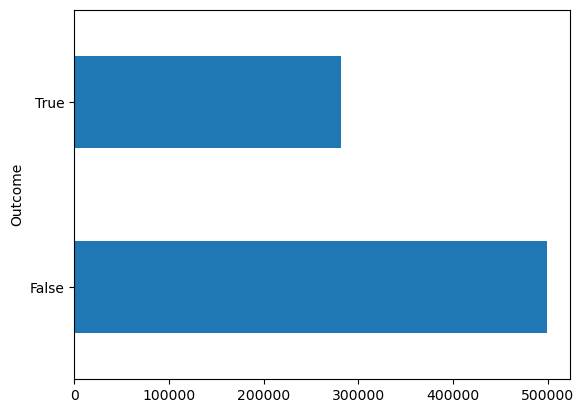

In [453]:
dataset['Outcome'].value_counts().plot.barh()

In [454]:
dataset.groupby('Gender', observed=True)['Outcome'].mean() # Se percentuale grande può causare leakage

Gender
Female    0.361486
Male      0.360777
Name: Outcome, dtype: float64

In [455]:
dataset.groupby('Gender', observed=True).size()

Gender
Female    386748
Male      393847
dtype: int64

In [456]:
dataset.describe()

,Age,BloodPressure
count,780595.000000,780595.000000
mean,57.148379,133.499806
std,15.778362,24.248001
min,20.000000,61.000000
25%,44.000000,114.000000
50%,57.000000,133.000000
75%,70.000000,153.000000
max,90.000000,199.000000


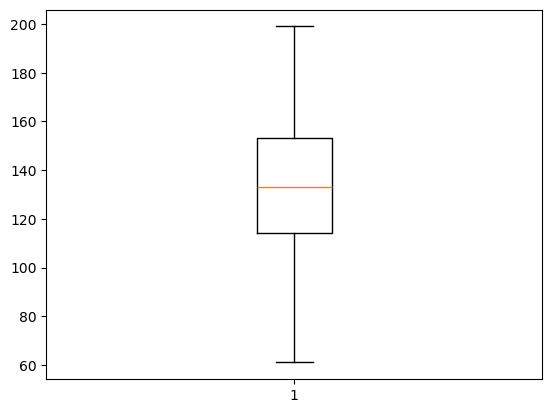

In [457]:
plt.boxplot(x="BloodPressure", data=dataset);  # NON ABBIAMO OUTLIERS

<Axes: ylabel='Smoker'>

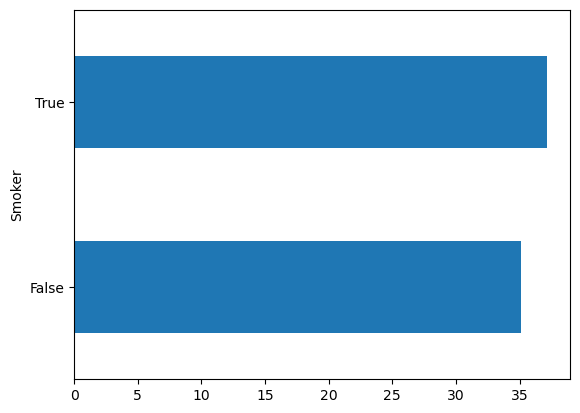

In [458]:
targetCorrelation(dataset, 'Smoker').plot.barh()

<Axes: ylabel='Cholesterol'>

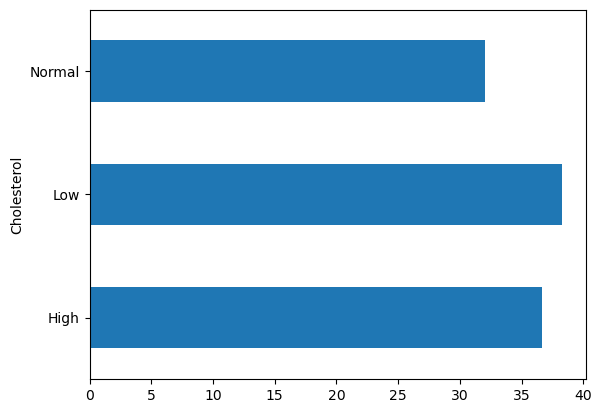

In [459]:
targetCorrelation(dataset, 'Cholesterol').plot.barh()

<Axes: ylabel='StressLevel'>

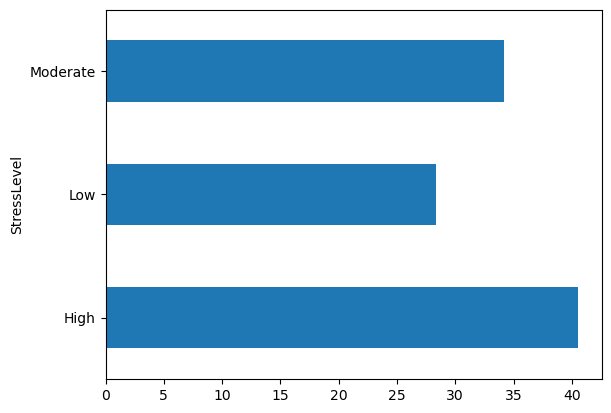

In [460]:
targetCorrelation(dataset, 'StressLevel').plot.barh()

<Axes: ylabel='Hypertension'>

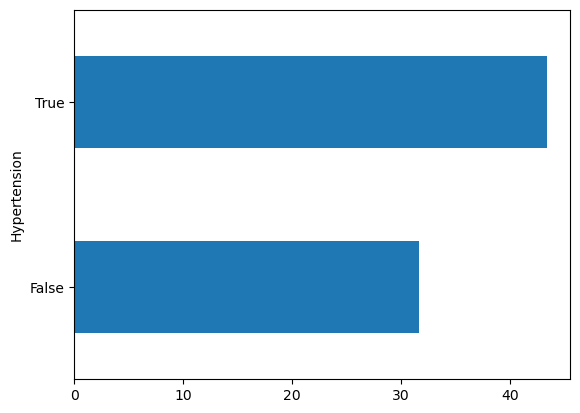

In [462]:
targetCorrelation(dataset, 'Hypertension').plot.barh()

<Axes: ylabel='PhysicalActivity'>

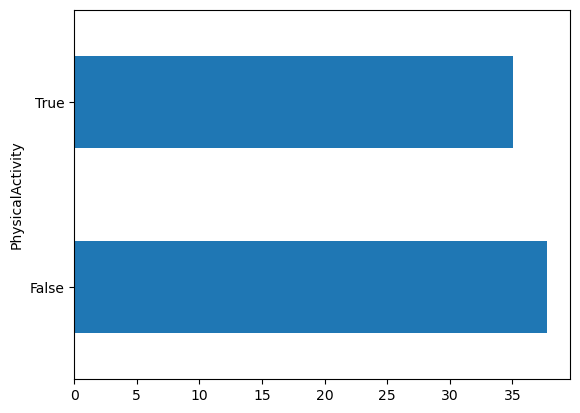

In [463]:
targetCorrelation(dataset, 'PhysicalActivity').plot.barh()

<Axes: ylabel='HealthyDiet'>

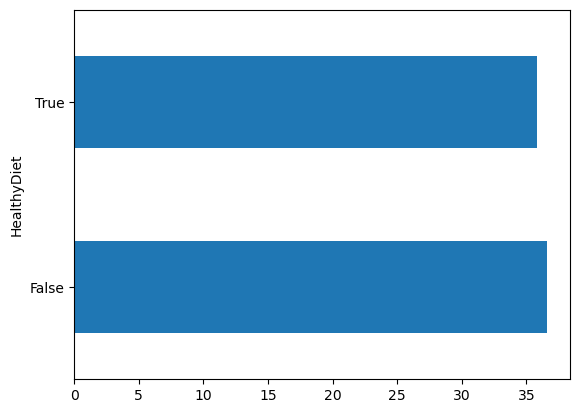

In [464]:
targetCorrelation(dataset, 'HealthyDiet').plot.barh()

<Axes: ylabel='IncomeLevel'>

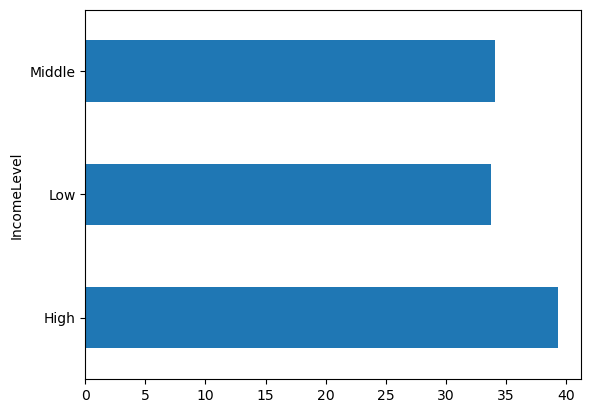

In [465]:
targetCorrelation(dataset, 'IncomeLevel').plot.barh()

<Axes: ylabel='FamilyHistory'>

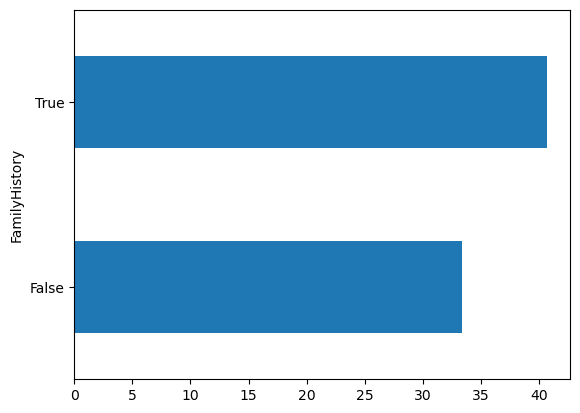

In [466]:
targetCorrelation(dataset, 'FamilyHistory').plot.barh()

<Axes: ylabel='PreviousHeartAttack'>

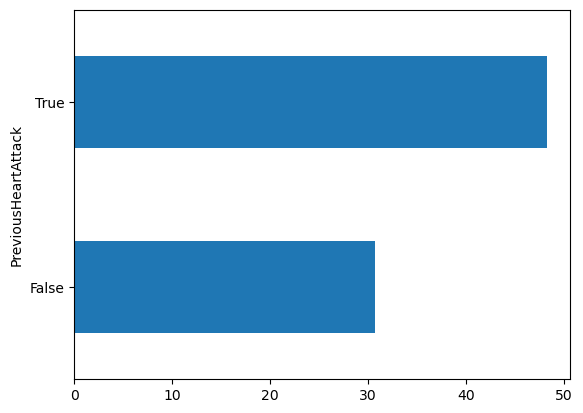

In [467]:
targetCorrelation(dataset, 'PreviousHeartAttack').plot.barh()

In [468]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve)
import seaborn as sns

# ========================================
# SETUP
# ========================================
X = dataset.drop('Outcome', axis=1)
y = dataset['Outcome'].astype(int)

numeric_features = ['Age', 'BloodPressure']
binary_features = ['Smoker', 'Hypertension', 'Diabetes', 'Obesity',
                   'PhysicalActivity', 'HealthyDiet', 'AlcoholConsumption',
                   'FamilyHistory', 'PreviousHeartAttack']
categorical_features = ['Gender', 'Cholesterol', 'StressLevel', 'IncomeLevel']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("="*60)
print("CLASSIFICAZIONE CON LOGISTIC REGRESSION + ELASTIC NET")
print("="*60 + "\n")

# Distribuzione classi
print(f"Distribuzione classi training:")
print(f"  No Outcome: {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"  Outcome: {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")
print(f"  Ratio: {np.sum(y_train==0)/np.sum(y_train==1):.2f}:1\n")



CLASSIFICAZIONE CON LOGISTIC REGRESSION + ELASTIC NET

Distribuzione classi training:
  No Outcome: 398960 (63.9%)
  Outcome: 225516 (36.1%)
  Ratio: 1.77:1



In [ ]:
# ========================================
# LOGISTIC REGRESSION CON ELASTIC NET
# ========================================
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=10000,
        random_state=42,
        class_weight='balanced',  # ⭐ gestisce lo sbilanciamento
        n_jobs=-1
    ))
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

# Usa F1 score per bilanciare precision e recall
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',  # meglio di accuracy per classi sbilanciate
    n_jobs=-1,
    verbose=1
)

print("Inizio Grid Search con Logistic Regression...\n")
grid_search.fit(X_train, y_train)

print(f"\n✓ Grid Search completata!")
print(f"Migliori parametri:")
print(f"  - C: {grid_search.best_params_['classifier__C']}")
print(f"  - L1 ratio: {grid_search.best_params_['classifier__l1_ratio']}")
print(f"  - F1 score CV: {grid_search.best_score_:.4f}\n")



Inizio Grid Search con Logistic Regression...

Fitting 5 folds for each of 36 candidates, totalling 180 fits

✓ Grid Search completata!
Migliori parametri:
  - C: 1.0
  - L1 ratio: 1.0
  - F1 score CV: 0.5458



In [470]:
# ========================================
# VALUTAZIONE
# ========================================
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

print("="*60)
print("METRICHE DI CLASSIFICAZIONE")
print("="*60 + "\n")

print("TRAINING SET:")
print(classification_report(y_train, y_pred_train, 
                          target_names=['No Outcome', 'Outcome']))
print(f"ROC-AUC: {roc_auc_score(y_train, y_pred_proba_train):.4f}\n")

print("TEST SET:")
print(classification_report(y_test, y_pred_test, 
                          target_names=['No Outcome', 'Outcome']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}\n")



METRICHE DI CLASSIFICAZIONE

TRAINING SET:
              precision    recall  f1-score   support

  No Outcome       0.75      0.63      0.68    398960
     Outcome       0.49      0.62      0.55    225516

    accuracy                           0.63    624476
   macro avg       0.62      0.63      0.61    624476
weighted avg       0.65      0.63      0.63    624476

ROC-AUC: 0.6624

TEST SET:
              precision    recall  f1-score   support

  No Outcome       0.74      0.63      0.68     99740
     Outcome       0.49      0.62      0.54     56379

    accuracy                           0.63    156119
   macro avg       0.62      0.62      0.61    156119
weighted avg       0.65      0.63      0.63    156119

ROC-AUC: 0.6621



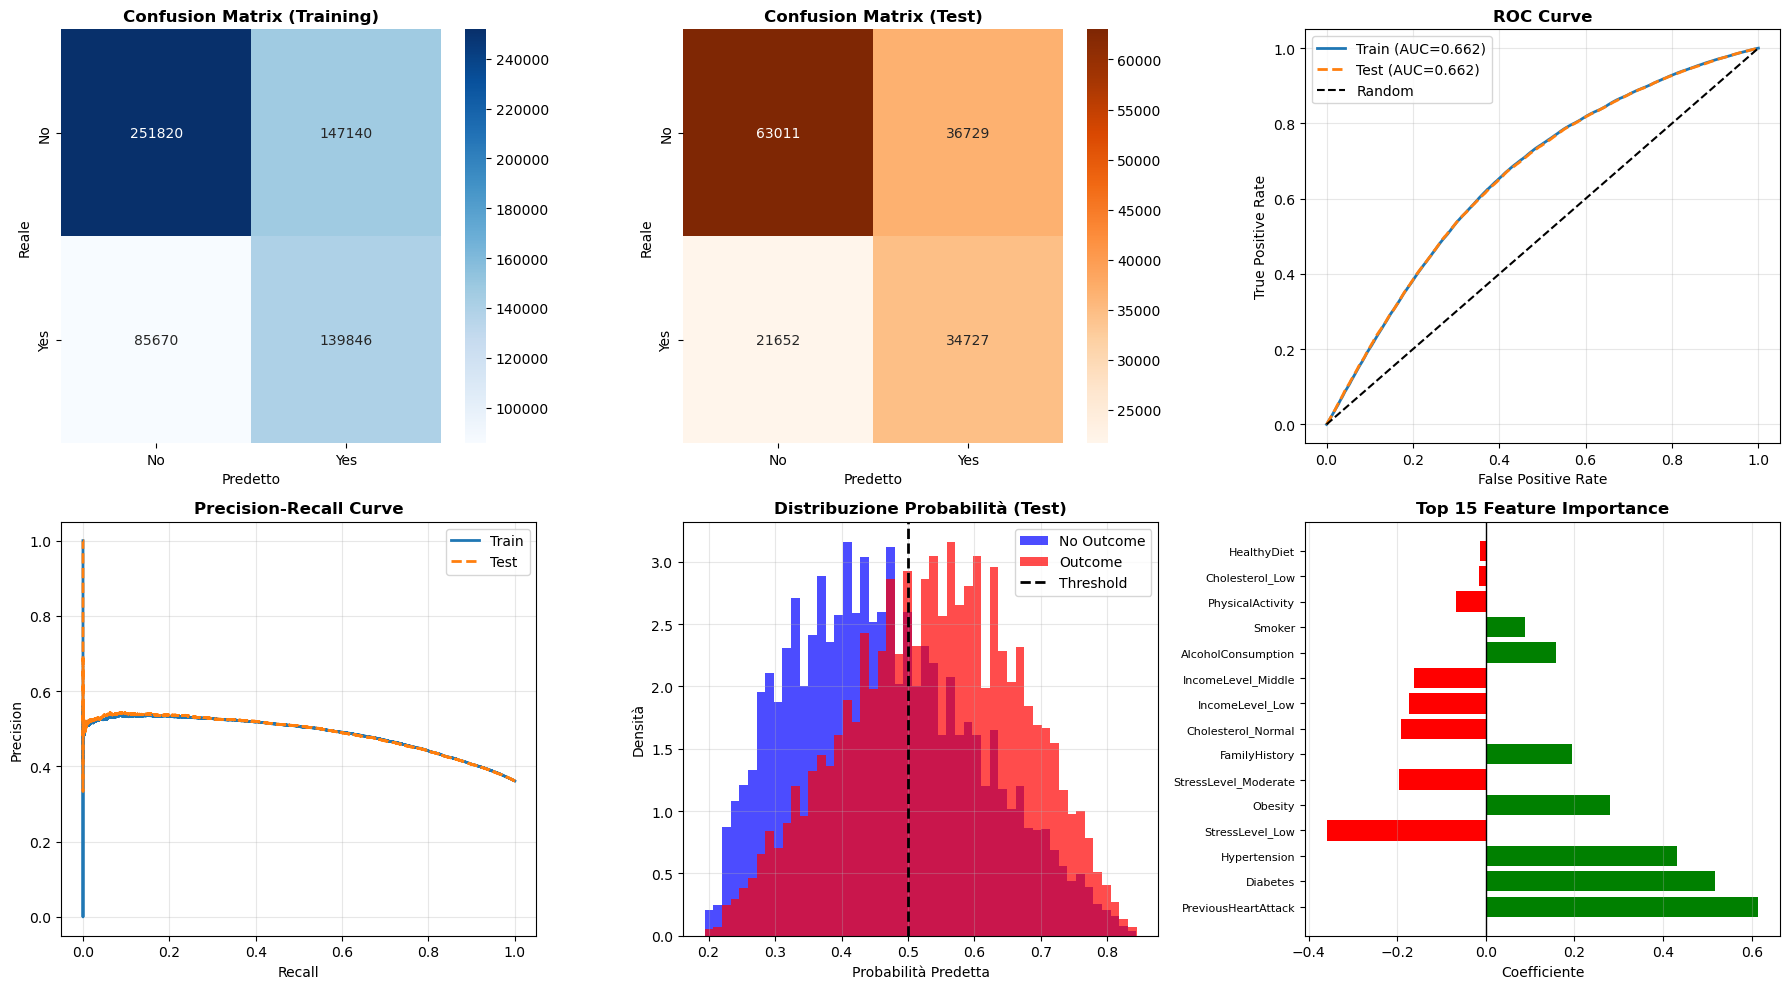


ANALISI THRESHOLD OTTIMALE

Threshold    Precision    Recall       F1          
------------------------------------------------
0.3          0.381        0.960        0.546       
0.4          0.426        0.840        0.566       
0.5          0.486        0.616        0.543       
0.6          0.525        0.340        0.412       
0.7          0.539        0.112        0.186       

💡 Suggerimento: abbassa il threshold (es: 0.3-0.4) per aumentare il recall!


In [474]:
# ========================================
# GRAFICI
# ========================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Confusion Matrix (Train)
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
axes[0, 0].set_xlabel('Predetto')
axes[0, 0].set_ylabel('Reale')
axes[0, 0].set_title('Confusion Matrix (Training)', fontweight='bold')

# 2. Confusion Matrix (Test)
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1],
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
axes[0, 1].set_xlabel('Predetto')
axes[0, 1].set_ylabel('Reale')
axes[0, 1].set_title('Confusion Matrix (Test)', fontweight='bold')

# 3. ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)

axes[0, 2].plot(fpr_train, tpr_train, label=f'Train (AUC={roc_auc_score(y_train, y_pred_proba_train):.3f})', 
                linewidth=2)
axes[0, 2].plot(fpr_test, tpr_test, label=f'Test (AUC={roc_auc_score(y_test, y_pred_proba_test):.3f})', 
                linewidth=2, linestyle='--')
axes[0, 2].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('ROC Curve', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Precision-Recall Curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)

axes[1, 0].plot(recall_train, precision_train, label='Train', linewidth=2)
axes[1, 0].plot(recall_test, precision_test, label='Test', linewidth=2, linestyle='--')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Distribuzione probabilità predette
axes[1, 1].hist(y_pred_proba_test[y_test==0], bins=50, alpha=0.7, 
                label='No Outcome', color='blue', density=True)
axes[1, 1].hist(y_pred_proba_test[y_test==1], bins=50, alpha=0.7, 
                label='Outcome', color='red', density=True)
axes[1, 1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1, 1].set_xlabel('Probabilità Predetta')
axes[1, 1].set_ylabel('Densità')
axes[1, 1].set_title('Distribuzione Probabilità (Test)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Feature Importance (coefficienti)
coefficients = best_model.named_steps['classifier'].coef_[0]

feature_names = []
feature_names.extend(numeric_features)
fitted_preprocessor = best_model.named_steps['preprocessor']
cat_features = fitted_preprocessor.named_transformers_['cat'] \
    .get_feature_names_out(categorical_features)

feature_names.extend(cat_features)
feature_names.extend(binary_features)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False).head(15)

colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
axes[1, 2].barh(range(len(coef_df)), coef_df['Coefficient'], color=colors)
axes[1, 2].set_yticks(range(len(coef_df)))
axes[1, 2].set_yticklabels(coef_df['Feature'], fontsize=8)
axes[1, 2].set_xlabel('Coefficiente')
axes[1, 2].set_title('Top 15 Feature Importance', fontweight='bold')
axes[1, 2].axvline(0, color='black', linewidth=1)
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ========================================
# ANALISI THRESHOLD
# ========================================
print("\n" + "="*60)
print("ANALISI THRESHOLD OTTIMALE")
print("="*60 + "\n")

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 48)

from sklearn.metrics import precision_score, recall_score, f1_score

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_test >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"{thresh:<12.1f} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f}")

print("\n💡 Suggerimento: abbassa il threshold (es: 0.3-0.4) per aumentare il recall!")

In [480]:
# PREPROCESSOR PER XGBOOST

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
         categorical_features),
        ('bin', 'passthrough', binary_features)
    ]
)

In [483]:
# PIPELINE (con gestione sbilanciamento)
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()  # 🔥
    ))
])

In [484]:
# GRID SEARCH (light)

param_grid_xgb = {
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.03, 0.05, 0.1],
    'classifier__n_estimators': [200, 300],
}

from sklearn.model_selection import GridSearchCV

grid_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid_xgb,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Users\miria\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:49:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['Age',
                                                                          'BloodPressure']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'Cholesterol',
                                                                          'StressLevel',
                                                                          'IncomeLevel']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['Smoker',
                                                                          'Hypertension',
                                                                          'Diabetes',
                                                                          'Obesity',
                                                                          'PhysicalActivity',
                                                                          'HealthyDiet'...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=4,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.03, 0.05, 0.1],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [200, 300]},
             scoring='f1', verbose=1)

In [485]:
# VALUTAZIONE COME LOGISTIC REGR
best_xgb = grid_xgb.best_estimator_

y_pred_test_xgb = best_xgb.predict(X_test)
y_proba_test_xgb = best_xgb.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score

print("XGBOOST – TEST SET")
print(classification_report(y_test, y_pred_test_xgb,
                            target_names=['No Outcome', 'Outcome']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_test_xgb):.3f}")

XGBOOST – TEST SET
              precision    recall  f1-score   support

  No Outcome       0.77      0.58      0.66     99740
     Outcome       0.48      0.69      0.57     56379

    accuracy                           0.62    156119
   macro avg       0.63      0.64      0.62    156119
weighted avg       0.67      0.62      0.63    156119

ROC-AUC: 0.682


In [487]:
# CONFRONTO TRA I DUE MODELLI
from sklearn.metrics import (
    classification_report, roc_auc_score,
    precision_score, recall_score, f1_score
)

print("="*70)
print("CONFRONTO FINALE MODELLI – TEST SET")
print("="*70)

models = {
    "Logistic Regression": (y_pred_test, y_pred_proba_test),
    "XGBoost": (y_pred_test_xgb, y_proba_test_xgb)
}

for name, (y_pred, y_proba) in models.items():
    print(f"\n{name}")
    print("-"*70)
    print(classification_report(
        y_test, y_pred,
        target_names=['No Outcome', 'Outcome']
    ))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"Recall Outcome: {recall_score(y_test, y_pred):.3f}")
    print(f"Precision Outcome: {precision_score(y_test, y_pred):.3f}")
    print(f"F1 Outcome: {f1_score(y_test, y_pred):.3f}")


CONFRONTO FINALE MODELLI – TEST SET

Logistic Regression
----------------------------------------------------------------------
              precision    recall  f1-score   support

  No Outcome       0.74      0.63      0.68     99740
     Outcome       0.49      0.62      0.54     56379

    accuracy                           0.63    156119
   macro avg       0.62      0.62      0.61    156119
weighted avg       0.65      0.63      0.63    156119

ROC-AUC: 0.662
Recall Outcome: 0.616
Precision Outcome: 0.486
F1 Outcome: 0.543

XGBoost
----------------------------------------------------------------------
              precision    recall  f1-score   support

  No Outcome       0.77      0.58      0.66     99740
     Outcome       0.48      0.69      0.57     56379

    accuracy                           0.62    156119
   macro avg       0.63      0.64      0.62    156119
weighted avg       0.67      0.62      0.63    156119

ROC-AUC: 0.682
Recall Outcome: 0.694
Precision Outcome: 0.

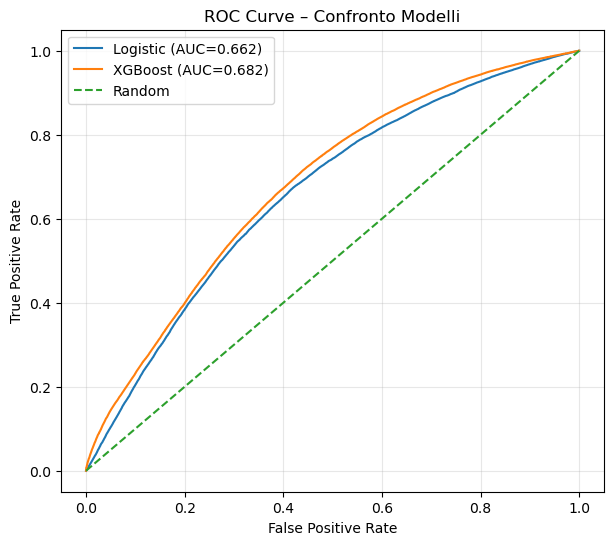

In [488]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_test_xgb)

plt.figure(figsize=(7, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={roc_auc_score(y_test, y_pred_proba_test):.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={roc_auc_score(y_test, y_proba_test_xgb):.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Confronto Modelli")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

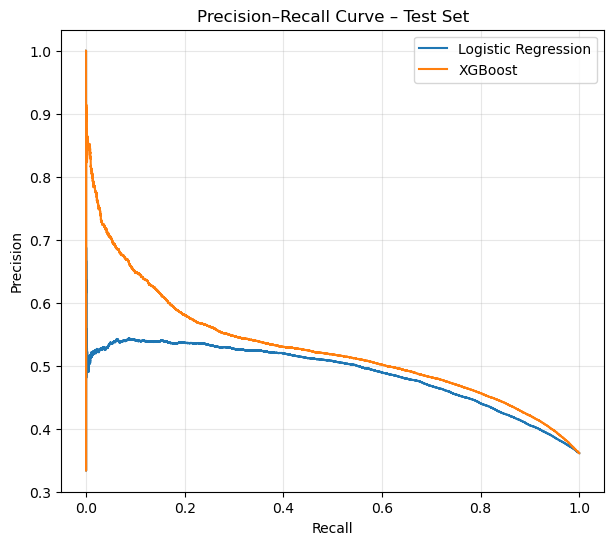

In [489]:
from sklearn.metrics import precision_recall_curve

prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_pred_proba_test)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_test_xgb)

plt.figure(figsize=(7, 6))
plt.plot(rec_lr, prec_lr, label="Logistic Regression")
plt.plot(rec_xgb, prec_xgb, label="XGBoost")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Test Set")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
